## Human activities classification 

#### Import libraries 

In [55]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import keras
from keras import regularizers
from keras.layers import Input, Dense, GlobalAveragePooling1D, MaxPooling1D
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv1D, BatchNormalization, Activation, concatenate
from keras.layers import LSTM, Flatten
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
import keras.backend as K
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.layers import TimeDistributed
from keras.layers import Bidirectional, Embedding
from keras.models import Sequential

#### Hyper-parameters 

In [56]:
RANDOM_SEED = 13

# Data preprocessing
TIME_STEP = 100

# Model
N_CLASSES = 6
N_FEATURES = 3  # x-acceleration, y-acceleration, z-acceleration

# Hyperparameters
N_LSTM_LAYERS = 2
N_EPOCHS = 15
L2_LOSS = 0.0015
LEARNING_RATE = 0.0025

# Hyperparameters optimized
SEGMENT_TIME_SIZE = 180
N_HIDDEN_NEURONS = 30
BATCH_SIZE = 32

#### Load data 
Each datum is a 3-dimensional time series (x,y and z directions of accelerometer)

In [57]:
##################################################
### GLOBAL VARIABLES
##################################################
COLUMN_NAMES = [
    'user',
    'activity',
    'timestamp',
    'x-axis',
    'y-axis',
    'z-axis'
]

LABELS = [
    'Downstairs',
    'Jogging',
    'Sitting',
    'Standing',
    'Upstairs',
    'Walking'
]

DATA_PATH = 'data/WISDM_ar_v1.1_raw.txt'
data = pd.read_csv(DATA_PATH, header=None, names=COLUMN_NAMES)
data['z-axis'].replace({';': ''}, regex=True, inplace=True)
data = data.dropna()

#### Define model 
Model 1 is inspired by Paper: "Convolutional Neural Networks for human activity recognition using mobile sensors", Ming Zeng, et al, 2014
https://ieeexplore.ieee.org/document/7026300

In [58]:
def model1():
    ip = keras.layers.Input(shape=(SEGMENT_TIME_SIZE, 1), name='main_input')
    conv1 = keras.layers.Conv1D(filters=128, kernel_size=8, padding='same')(ip)
    conv1 = keras.layers.normalization.BatchNormalization()(conv1)
    conv1 = keras.layers.Activation(activation='relu')(conv1)

    conv2 = keras.layers.Conv1D(filters=256, kernel_size=5, padding='same')(conv1)
    conv2 = keras.layers.normalization.BatchNormalization()(conv2)
    conv2 = keras.layers.Activation('relu')(conv2)

    conv3 = keras.layers.Conv1D(128, kernel_size=3,padding='same')(conv2)
    conv3 = keras.layers.normalization.BatchNormalization()(conv3)
    conv3 = keras.layers.Activation('relu')(conv3)

    gap_layer = keras.layers.pooling.GlobalAveragePooling1D()(conv3)
    out = keras.layers.Dense(N_CLASSES, activation='softmax')(gap_layer)
    
    model = Model(ip, out)
    model.summary()
    
    return model

#### Training 

In [59]:
# DATA PREPROCESSING
data_convoluted = []
labels = []

# Slide a "SEGMENT_TIME_SIZE" wide window with a step size of "TIME_STEP"
for i in range(0, len(data) - SEGMENT_TIME_SIZE, TIME_STEP):
    x = data['x-axis'].values[i: i + SEGMENT_TIME_SIZE]
    #y = data['y-axis'].values[i: i + SEGMENT_TIME_SIZE]
    #z = data['z-axis'].values[i: i + SEGMENT_TIME_SIZE]
    #data_convoluted.append([x, y, z])
    data_convoluted.append([x])

    # Label for a data window is the label that appears most commonly
    label = stats.mode(data['activity'][i: i + SEGMENT_TIME_SIZE])[0][0]
    labels.append(label)

# Convert to numpy
data_convoluted = np.asarray(data_convoluted, dtype=np.float32).transpose(0, 2, 1)

# One-hot encoding
labels = np.asarray(pd.get_dummies(labels), dtype=np.float32)
print("Convoluted data shape: ", data_convoluted.shape)
print("Labels shape:", labels.shape)

# SPLIT INTO TRAINING AND TEST SETS
X_train1, X_test, y_train1, y_test = train_test_split(data_convoluted, labels, test_size=0.2, random_state=RANDOM_SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=0.25, random_state=RANDOM_SEED)
print("X train size: ", len(X_train))
print("X test size: ", len(X_test))
print("X val size: ", len(X_val))
print("y train size: ", len(y_train))
print("y test size: ", len(y_test))
print("y val size: ", len(y_val))

Convoluted data shape:  (10981, 180, 1)
Labels shape: (10981, 6)
X train size:  6588
X test size:  2197
X val size:  2196
y train size:  6588
y test size:  2197
y val size:  2196


In [60]:
######### Training #########
weight_fn = "./weights_simon2.h5"
model_checkpoint = ModelCheckpoint(weight_fn, verbose=1, mode='max', monitor='val_acc', save_best_only=True, save_weights_only=True)
stop = EarlyStopping(monitor='val_loss', patience=15)
callback_list = [model_checkpoint, stop]
optm = Adam(lr=LEARNING_RATE)

model = model1()

model.compile(optimizer=optm, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS, callbacks = callback_list, verbose=2, validation_data=(X_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 180, 1)            0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 180, 128)          1152      
_________________________________________________________________
batch_normalization_16 (Batc (None, 180, 128)          512       
_________________________________________________________________
activation_16 (Activation)   (None, 180, 128)          0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 180, 256)          164096    
_________________________________________________________________
batch_normalization_17 (Batc (None, 180, 256)          1024      
_________________________________________________________________
activation_17 (Activation)   (None, 180, 256)          0         
__________

#### Prediction 

In [61]:
model.load_weights(weight_fn)
prediction = model.predict(X_test);
p_pred = np.argmax(prediction, axis=1)
p_test = np.argmax(y_test, axis=1)
    
cr = classification_report(p_test, p_pred)
cm = confusion_matrix(p_test, p_pred)
    
print("-------------------- Result -----------------------")
acc = np.sum(p_pred == p_test)/p_pred.shape[0]
print('Accuracy: ' + str(acc))
print(cr)
print(cm)

-------------------- Result -----------------------
Accuracy: 0.8857532999544834
              precision    recall  f1-score   support

           0       0.60      0.86      0.71       212
           1       0.98      0.97      0.97       676
           2       0.75      0.86      0.80       140
           3       0.66      0.45      0.53        78
           4       0.80      0.53      0.64       258
           5       0.97      0.98      0.97       833

   micro avg       0.89      0.89      0.89      2197
   macro avg       0.80      0.77      0.77      2197
weighted avg       0.89      0.89      0.88      2197

[[183   2   0   0  21   6]
 [ 10 656   0   0   2   8]
 [  0   0 120  18   2   0]
 [  0   1  39  35   3   0]
 [ 99  11   0   0 136  12]
 [ 12   0   0   0   5 816]]


#### Loss and accuracy 

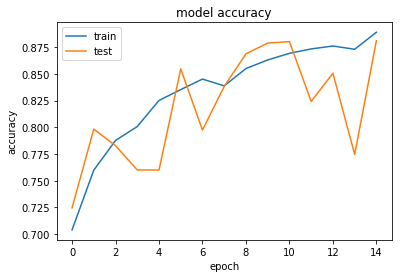

In [62]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

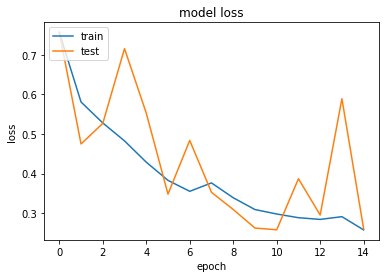

In [63]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

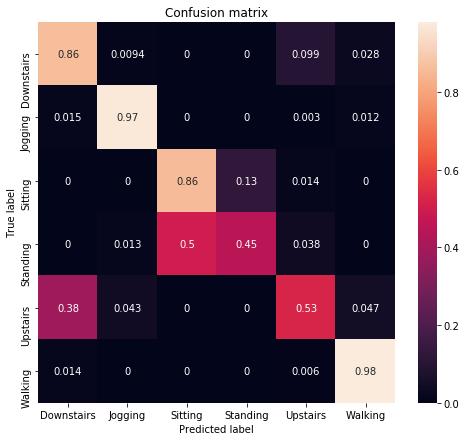

In [64]:
# CONFUSION MATRIX
plt.figure(figsize=(8, 7))
sns.heatmap(cm/(np.sum(cm, axis=1, keepdims=1)), xticklabels=LABELS, yticklabels=LABELS, annot=True);
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Class Activation Map 

In [19]:
[model.layers[-3].output, model.layers[-1].output]

[<tf.Tensor 'activation_12/Relu:0' shape=(?, 180, 128) dtype=float32>,
 <tf.Tensor 'dense_3/Softmax:0' shape=(?, 6) dtype=float32>]

In [65]:
labels_test = np.argmax(y_test, axis=1)
labels_test

array([1, 5, 2, ..., 0, 1, 4], dtype=int64)

In [66]:
classes = np.unique(labels_test)
classes

array([0, 1, 2, 3, 4, 5], dtype=int64)

In [67]:
# the same input
new_input_layer = model.inputs
# output is both the original as well as the before last layer
new_output_layer = [model.layers[-3].output, model.layers[-1].output]

new_feed_forward = keras.backend.function(new_input_layer, new_output_layer)

In [154]:
# filters
w_k_c = model.layers[-1].get_weights()[0] #  weights for each filter k for each class c
w_k_c.shape

(128, 6)

In [149]:
from scipy.interpolate import spline
import scipy.interpolate as interpolate

In [144]:
labels_testaa = labels_test[0:27]
classesaa = np.unique(labels_testaa)
classesaa

array([0, 1, 2, 3, 4, 5], dtype=int64)

In [145]:
X_testaa = X_test[0:27,:,:]
X_testaa.shape

(27, 180, 1)

In [103]:
[conv_out, predicted] = new_feed_forward([X_test])

In [104]:
p_pred = np.argmax(predicted, axis=1)
p_test = np.argmax(y_test, axis=1)
    
cr = classification_report(p_test, p_pred)
cm = confusion_matrix(p_test, p_pred)
    
print("-------------------- Result -----------------------")
acc = np.sum(p_pred == p_test)/p_pred.shape[0]
print('Accuracy: ' + str(acc))
print(cr)
print(cm)

-------------------- Result -----------------------
Accuracy: 0.8857532999544834
              precision    recall  f1-score   support

           0       0.60      0.86      0.71       212
           1       0.98      0.97      0.97       676
           2       0.75      0.86      0.80       140
           3       0.66      0.45      0.53        78
           4       0.80      0.53      0.64       258
           5       0.97      0.98      0.97       833

   micro avg       0.89      0.89      0.89      2197
   macro avg       0.80      0.77      0.77      2197
weighted avg       0.89      0.89      0.88      2197

[[183   2   0   0  21   6]
 [ 10 656   0   0   2   8]
 [  0   0 120  18   2   0]
 [  0   1  39  35   3   0]
 [ 99  11   0   0 136  12]
 [ 12   0   0   0   5 816]]


In [120]:
c_x_train = X_test[np.where(labels_test==0)]
c_x_train.shape

(212, 180, 1)

In [117]:
c_y_train = y_test[np.where(labels_test==5)]
c_y_train

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

#### Using  spline

c =  0
(1, 180, 1)


C:\Users\xngu0004\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
C:\Users\xngu0004\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


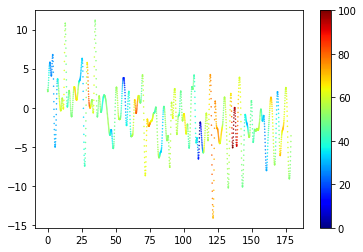

c =  1
(14, 180, 1)


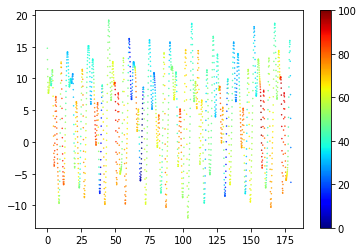

c =  2
(3, 180, 1)


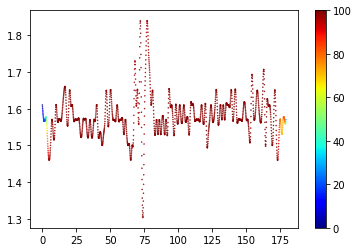

c =  3
(1, 180, 1)


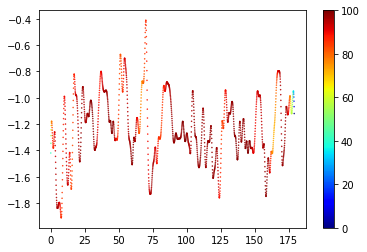

c =  4
(2, 180, 1)


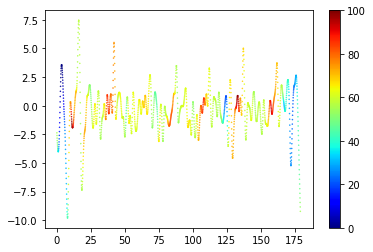

c =  5
(6, 180, 1)


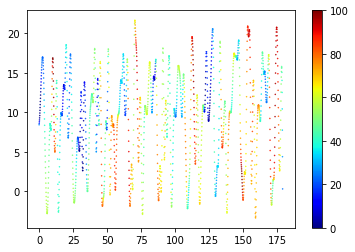

In [172]:
max_length = 2000
for c in classes:
    print("c = ", c)
    plt.figure()
    count =0
    count1 = 0
    c_x_train = X_testaa[np.where(labels_testaa==c)]
    print(c_x_train.shape)
    for ts in c_x_train:
        count1 += 1
        ts = ts.reshape(1,-1,1)
        [conv_out, predicted] = new_feed_forward([ts])
        pred_label = np.argmax(predicted)
        #print("conv_out shape = ", conv_out.shape)
        #print("pred_label = ", pred_label)
        if pred_label == c:
            count += 1
            if (count < 2):
                cas = np.zeros(dtype=np.float, shape=(conv_out.shape[1]))
                # k is order number: 0,1,2,3,...,127; w is corresponding weight
                for k, w in enumerate(w_k_c[:, c]):
                    cas += w * conv_out[0,:, k]
                    #print("k = ", k)
                    #print("w = ", w)

                #print("cas shape = ", cas.shape)
                minimum = np.min(cas)
                cas = cas - minimum
                cas = cas / max(cas)
                cas = cas * 100

                x = np.linspace(0,ts.shape[1]-1,max_length,endpoint=True)
                #print("x shape = ", x.shape)
                # linear interpolation to smooth
                y = spline(range(ts.shape[1]),ts[0,:,0],x)
                #print("y shape = ", y.shape)
                cas = spline(range(ts.shape[1]),cas,x)
                #print("cas shape = ", cas.shape)
                #print("cas = ", cas)
                cas = cas.astype(int)
                #print("cas int = ", cas)
                plt.scatter(x=x,y=y,c=cas,cmap='jet', marker='.',s=1,vmin=0,vmax = 100)
            
    #print("count = ", count)
    #print("count1 = ", count1)
    cbar = plt.colorbar()
    plt.show()
    #plt.savefig(root_dir+'/results/'+classifier+'/'+archive_name+'/'+dataset_name+'/'+str(int(c))+'.png',
                #bbox_inches='tight',dpi=1080)

#### Using Bspline class

c =  0
(1, 180, 1)


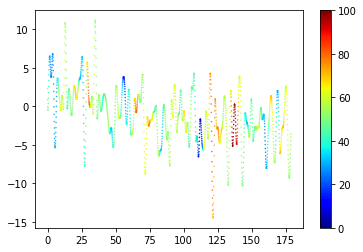

c =  1
(14, 180, 1)


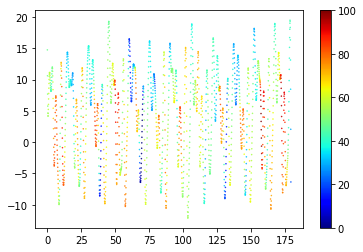

c =  2
(3, 180, 1)


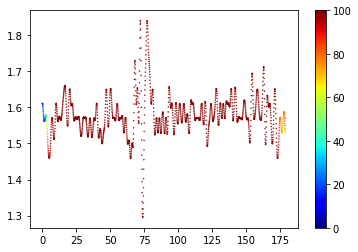

c =  3
(1, 180, 1)


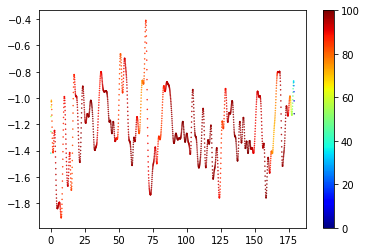

c =  4
(2, 180, 1)


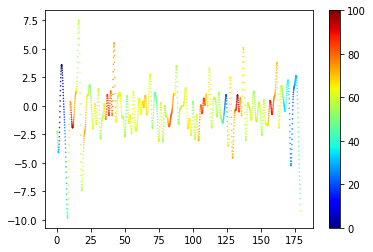

c =  5
(6, 180, 1)


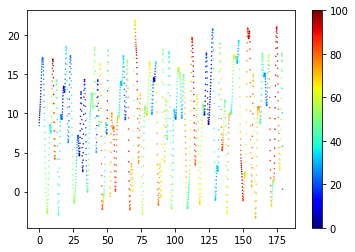

In [173]:
max_length = 2000
for c in classes:
    print("c = ", c)
    plt.figure()
    count =0
    count1 = 0
    c_x_train = X_testaa[np.where(labels_testaa==c)]
    #print(c_x_train.shape)
    for ts in c_x_train:
        count1 += 1
        ts = ts.reshape(1,-1,1)
        [conv_out, predicted] = new_feed_forward([ts])
        pred_label = np.argmax(predicted)
        #print("conv_out shape = ", conv_out.shape)
        #print("pred_label = ", pred_label)
        if pred_label == c:
            count += 1
            if (count < 2):
                cas = np.zeros(dtype=np.float, shape=(conv_out.shape[1]))
                # k is order number: 0,1,2,3,...,127; w is corresponding weight
                for k, w in enumerate(w_k_c[:, c]):
                    cas += w * conv_out[0,:, k]

                #print("cas shape = ", cas.shape)
                minimum = np.min(cas)
                cas = cas - minimum
                cas = cas / max(cas)
                cas = cas * 100
                
                xx = np.linspace(0,ts.shape[1]-1,ts.shape[1],endpoint=True)
                yy = ts.reshape(-1)
                t, cc, k = interpolate.splrep(xx, yy, s=0, k=5)
                t1, cc1, k1 = interpolate.splrep(xx, cas, s=0, k=5)
                x = np.linspace(0,ts.shape[1]-1,max_length,endpoint=True)

                y = interpolate.BSpline(t, cc, k, extrapolate=False)
                cas = interpolate.BSpline(t1, cc1, k1, extrapolate=False)
                
                plt.scatter(x=x,y=y(x),c=cas(x).astype(int),cmap='jet', marker='.',s=1,vmin=0,vmax = 100)
            
    #print("count = ", count)
    #print("count1 = ", count1)
    cbar = plt.colorbar()
    plt.show()
    #plt.savefig(root_dir+'/results/'+classifier+'/'+archive_name+'/'+dataset_name+'/'+str(int(c))+'.png',
                #bbox_inches='tight',dpi=1080)

In [152]:
x = np.linspace(0,9,20,endpoint=True)
x

array([0.        , 0.47368421, 0.94736842, 1.42105263, 1.89473684,
       2.36842105, 2.84210526, 3.31578947, 3.78947368, 4.26315789,
       4.73684211, 5.21052632, 5.68421053, 6.15789474, 6.63157895,
       7.10526316, 7.57894737, 8.05263158, 8.52631579, 9.        ])

In [157]:
ca = np.zeros(dtype=np.float, shape=(10))
ca.shape

(10,)